Student Name: Ayesha Saleem

Student Id: 22074385

# World Happiness Report - Data Preparation

This step loads the dataset, extracts files, and previews the 2019 data.

In [49]:
# Import necessary libraries
import pandas as pd
import zipfile
import os

zip_path = "/content/World Happiness Report.zip"
extract_path = "/content/World_Happiness_Report"

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Listing extracted files
extracted_files = os.listdir(extract_path)
print("Extracted Files:", extracted_files)

# Loading the 2019 dataset
file_path_2019 = os.path.join(extract_path, '2019.csv')
happiness_2019 = pd.read_csv(file_path_2019)

# Displaying the first few rows of the dataset
happiness_2019.head()

Extracted Files: ['2018.csv', '2015.csv', '2017.csv', '2016.csv', '2019.csv']


,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


Step 2: Exploratory Data Analysis (EDA)

## Correlation Heatmap

This heatmap shows the relationships between different variables in the dataset. Strong correlations are highlighted to identify key factors influencing happiness scores. The text annotations are bold for improved readability.

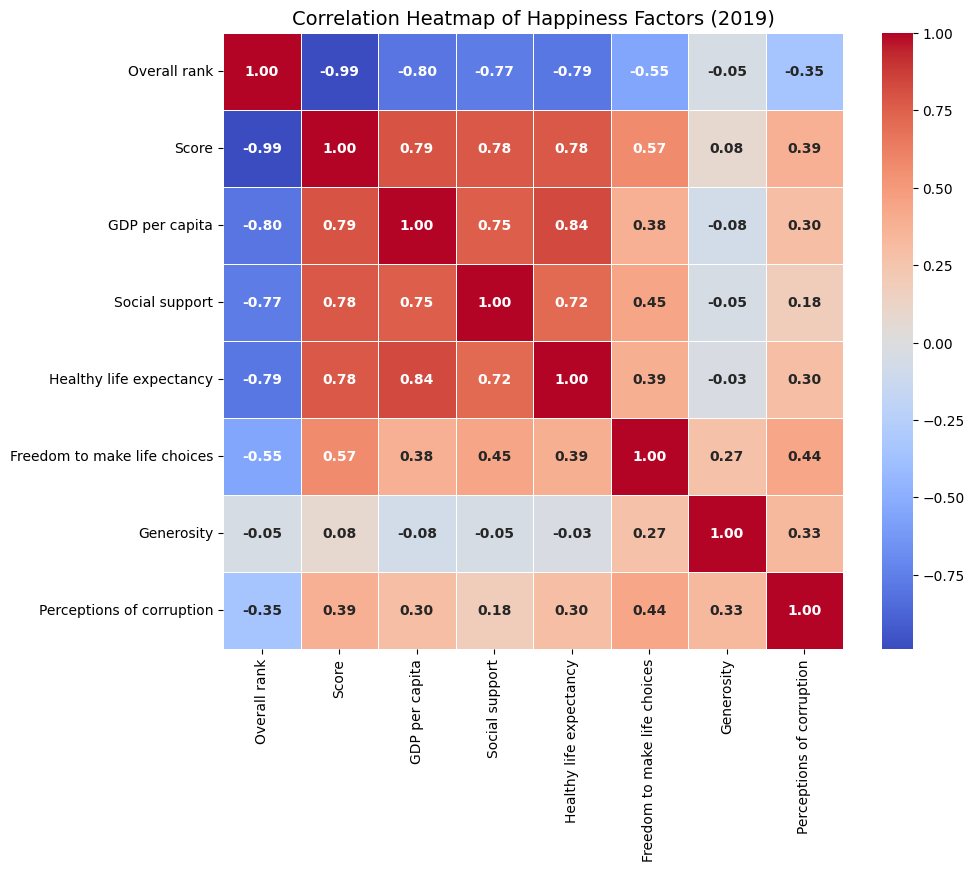

In [50]:
# Selecting only numeric columns for the correlation matrix
numeric_data = happiness_2019.select_dtypes(include=['float64', 'int64'])

# Heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    numeric_data.corr(),
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"weight": "bold"}
)
plt.title("Correlation Heatmap of Happiness Factors (2019)", fontsize=14)
plt.show()


## Feature Normalization and K-Means Clustering

This section includes:
1. **Normalization**: Normalizes the features to ensure they are on the same scale.
2. **Elbow Method**: Determines the optimal number of clusters by plotting inertia values.

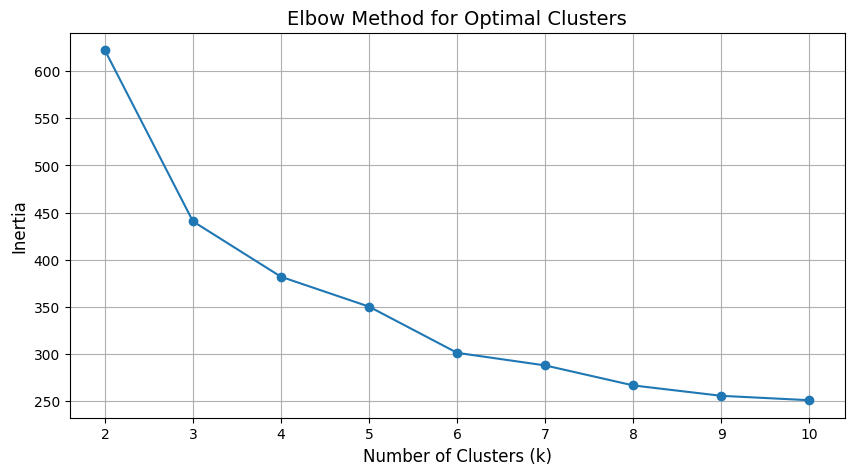

Silhouette Score for 4 clusters: 0.28


In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def normalize_features(data, feature_columns):

    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data[feature_columns])
    return normalized_data, scaler


def elbow_method(normalized_data, max_clusters=10):

    inertia = []
    cluster_range = range(2, max_clusters + 1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(normalized_data)
        inertia.append(kmeans.inertia_)

    # Plotting the Elbow Method
    plt.figure(figsize=(10, 5))
    plt.plot(cluster_range, inertia, marker='o')
    plt.title('Elbow Method for Optimal Clusters', fontsize=14)
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Inertia', fontsize=12)
    plt.grid(True)
    plt.show()

    return inertia


def silhouette_analysis(normalized_data, n_clusters):

# Define the features for clustering
features = ['GDP per capita', 'Social support', 'Healthy life expectancy',
            'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

# Step 1: Normalize the features
normalized_data, scaler = normalize_features(happiness_2019, features)

# Step 2: Use the Elbow Method to determine optimal clusters
elbow_inertia = elbow_method(normalized_data)

# Step 3: Perform silhouette analysis for a selected number of clusters (e.g., k=4)
silhouette_score_k4 = silhouette_analysis(normalized_data, n_clusters=4)

## K-Means Clustering and Visualization

In this step, we:
1. Perform K-Means clustering with the selected number of clusters.
2. Assign the cluster labels to the dataset.
3. Visualize the clustering results in a scatter plot.

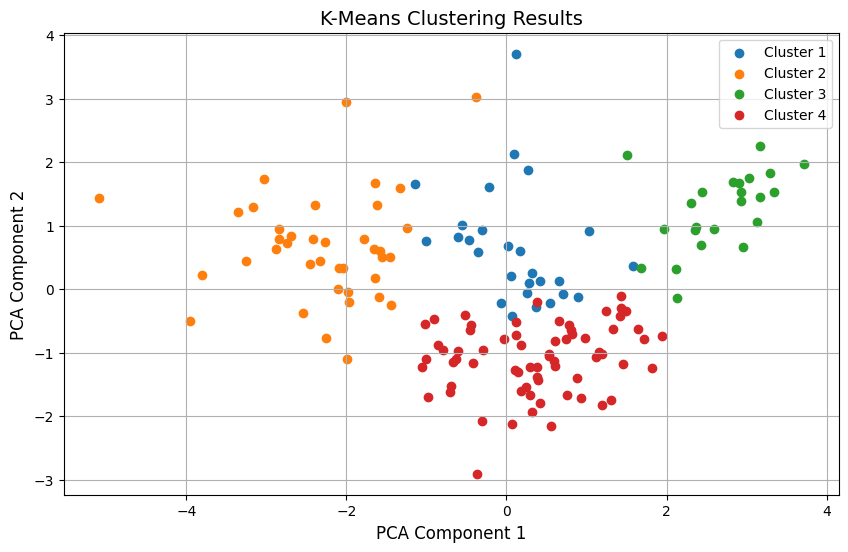

In [52]:
from sklearn.decomposition import PCA

def perform_kmeans(normalized_data, n_clusters):
    """
    Perform K-Means clustering on normalized data.

    Args:
        normalized_data (ndarray): Normalized data for clustering.
        n_clusters (int): Number of clusters to form.

    Returns:
        ndarray: Cluster labels for each data point.
        KMeans: Fitted KMeans model.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(normalized_data)
    return kmeans.labels_, kmeans


def visualize_clusters(normalized_data, cluster_labels, n_clusters):


    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(normalized_data)

    # Scatter plot of the clusters
    plt.figure(figsize=(10, 6))
    for cluster in range(n_clusters):
        cluster_points = reduced_data[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster+1}')

    plt.title('K-Means Clustering Results', fontsize=14)
    plt.xlabel('PCA Component 1', fontsize=12)
    plt.ylabel('PCA Component 2', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


# Step 1: Perform K-Means with optimal clusters (e.g., 4)
n_clusters = 4  # Change this based on the elbow graph
cluster_labels, kmeans_model = perform_kmeans(normalized_data, n_clusters)

# Step 2: Visualize the clustering results
visualize_clusters(normalized_data, cluster_labels, n_clusters)

# Assign cluster labels to the original dataset
happiness_2019['Cluster'] = cluster_labels

## Linear Regression for Happiness Score Prediction

This section involves:
1. Splitting the data into training and testing sets.
2. Training a linear regression model to predict happiness scores based on selected features.
3. Evaluating the model's performance using metrics such as R² and Mean Squared Error (MSE).
4. Visualizing the relationship between actual and predicted values.

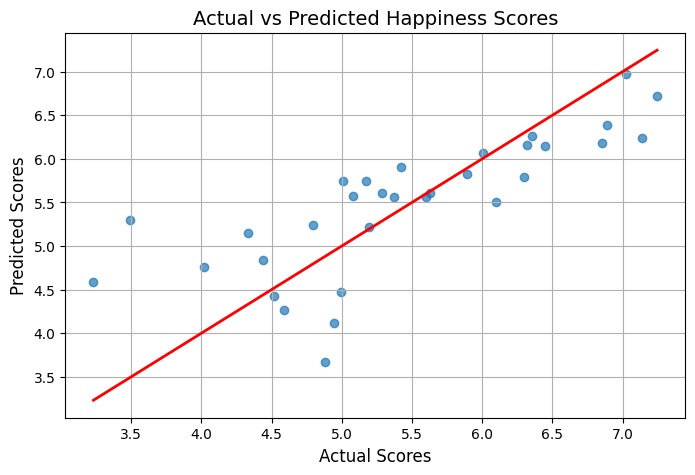

Model Evaluation Metrics:
{'R² Score': 0.6017537913445683, 'Mean Squared Error': 0.4144641383528352}


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def train_test_split_data(data, target_column, feature_columns, test_size=0.2, random_state=42):
    X = data[feature_columns]
    y = data[target_column]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def train_linear_regression(X_train, y_train):

    model = LinearRegression()
    model.fit(X_train, y_train)
    return model


def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)

    # Plotting actual vs predicted values
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test, predictions, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
    plt.title('Actual vs Predicted Happiness Scores', fontsize=14)
    plt.xlabel('Actual Scores', fontsize=12)
    plt.ylabel('Predicted Scores', fontsize=12)
    plt.grid(True)
    plt.show()

    return {"R² Score": r2, "Mean Squared Error": mse}


# Step 1: Split the data
target_column = 'Score'
feature_columns = ['GDP per capita', 'Social support', 'Healthy life expectancy',
                   'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

X_train, X_test, y_train, y_test = train_test_split_data(happiness_2019, target_column, feature_columns)

# Step 2: Train the regression model
regression_model = train_linear_regression(X_train, y_train)

# Step 3: Evaluate the model
evaluation_metrics = evaluate_model(regression_model, X_test, y_test)

# Display evaluation results
print("Model Evaluation Metrics:")
print(evaluation_metrics)

## Future Predictions and Confidence Intervals

In this section, we:
1. Use the trained regression model to predict happiness scores for hypothetical new data points.
2. Calculate and visualize confidence intervals for the predictions to quantify uncertainty.

In [60]:
def predict_with_intervals_refined(model, scaler, X_new, X_train, residuals, confidence=0.95):

    check_is_fitted(model)  # Ensure the model is fitted
    X_new_scaled = scaler.transform(X_new)  # Normalize the new data

    predictions = model.predict(X_new_scaled)  # Predictions for new data

    # Calculatin the mean squared error from residuals
    mse = np.mean(residuals**2)

    # Calculatin the leverages for new data points
    leverage = np.sum((X_new_scaled @ np.linalg.pinv(X_train.T @ X_train)) * X_new_scaled, axis=1)

    # Computin standard errors for predictions
    standard_errors = np.sqrt(mse * (1 + leverage))

    # Confidence intervals
    dof = len(X_train) - X_train.shape[1] - 1  # Degrees of freedom
    t_stat = t.ppf((1 + confidence) / 2, dof)
    delta = t_stat * standard_errors
    lower_bounds = predictions - delta
    upper_bounds = predictions + delta

    return predictions, lower_bounds, upper_bounds


# Use the function with refined calculations
predictions, lower_bounds, upper_bounds = predict_with_intervals_refined(
    model=regression_model,
    scaler=scaler,
    X_new=new_data,
    X_train=X_train,
    residuals=residuals
)

# Display predictions with intervals
for i, (pred, low, high) in enumerate(zip(predictions, lower_bounds, upper_bounds)):
    print(f"Example {i+1}: Predicted Score = {pred:.2f}, Confidence Interval = [{low:.2f}, {high:.2f}]")


Example 1: Predicted Score = 7.65, Confidence Interval = [4.80, 10.49]
Example 2: Predicted Score = 4.70, Confidence Interval = [-1.50, 10.90]
Example 3: Predicted Score = 10.62, Confidence Interval = [8.59, 12.64]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


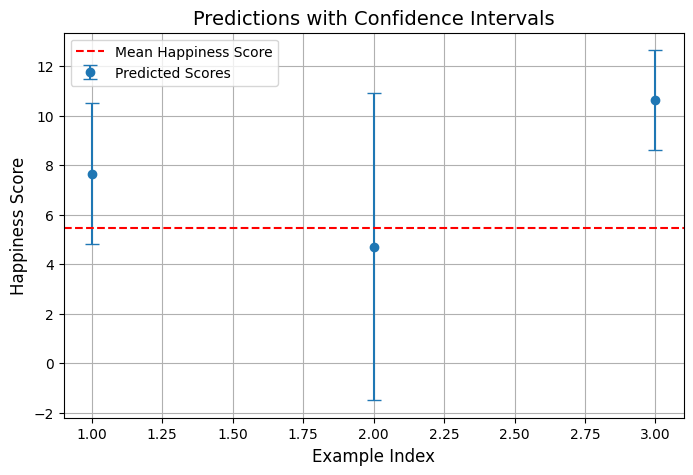

In [61]:
import matplotlib.pyplot as plt

examples = [1, 2, 3]
plt.figure(figsize=(8, 5))
plt.errorbar(examples, predictions, yerr=[predictions - lower_bounds, upper_bounds - predictions], fmt='o', capsize=5, label='Predicted Scores')
plt.axhline(y=np.mean(y_test), color='red', linestyle='--', label='Mean Happiness Score')
plt.title('Predictions with Confidence Intervals', fontsize=14)
plt.xlabel('Example Index', fontsize=12)
plt.ylabel('Happiness Score', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
